<a href="https://colab.research.google.com/github/Hrithik2212/PyTorch-Deep-Learning-/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification

# Problem 1 - Binary Classication 

## Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
X.shape,y.shape

((1000, 2), (1000,))

In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

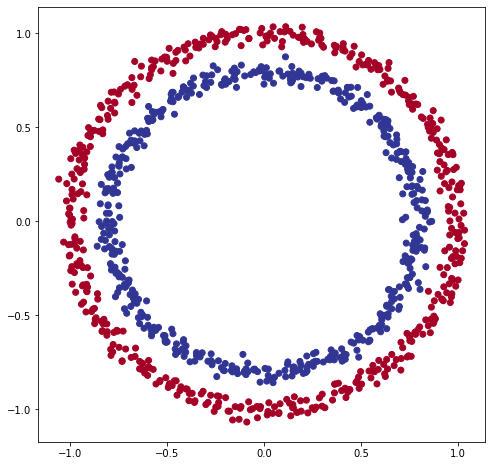

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);


##  Turn data into tensors and create train and test splits

In [6]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [7]:
from sklearn.model_selection import train_test_split
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a Model 

In [8]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
!CUDA_LAUNCH_BLOCKING=1.

In [10]:
class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
    
  def forward(self,x):
    return self.layer_2(self.layer_1(x))

Model_0 = CircleModelV0().to(device)
Model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
next(Model_0.parameters())

Parameter containing:
tensor([[ 0.3007,  0.0729],
        [ 0.0895,  0.0314],
        [-0.6248,  0.6713],
        [ 0.1985, -0.4694],
        [ 0.3014, -0.5601]], device='cuda:0', requires_grad=True)

In [12]:
untrained_preds = Model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2725],
        [-0.2772],
        [-0.4495],
        [-0.2215],
        [-0.7505],
        [-0.7511],
        [-0.5260],
        [-0.6377],
        [-0.4366],
        [-0.2809]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Loss Function and Optimizer

In [13]:
loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(params=Model_0.parameters(), 
                            lr=0.1)
optimizer_2 = torch.optim.SGD(params=Model_0.parameters(), 
                            lr=0.1)

## Creating an Evaluation Metric 

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Train Model 
1) Forward Pass

2) Calculate Loss

3) Optimizer Zero Grad

4) Loss Backward (Back Propagation)

5) Optimzer step (Gradient Descent)


In [15]:
Model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
y_logits = Model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2725],
        [-0.2772],
        [-0.4495],
        [-0.2215],
        [-0.7505]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4323],
        [0.4311],
        [0.3895],
        [0.4449],
        [0.3207]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [19]:
y_pred_labels = torch.round(torch.sigmoid(Model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [20]:
y_pred_labels.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
!smi nvidia 

/bin/bash: smi: command not found


## Building a Train and Test loop  

In [22]:
torch.manual_seed(42)
epochs = 101
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)
for epoch in range(epochs):
  Model_0.train()
  # Foward Pass
  y_logits = Model_0(X_train).squeeze()
  y_pred = torch.round(y_logits)
  # Calculate Loss and Accuracy 
  loss = loss_fn(torch.sigmoid(y_logits),y_train)

  acc = accuracy_fn(y_train,y_pred)
  # Optimizer Zero Grad
  optimizer_2.zero_grad()

  # Back Propagation 
  loss.backward()

  # Optimizer Gradient Descent 
  with torch.inference_mode():
    # Foward Pasdd
    test_logits = Model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate Loss and Accuracy 
    test_loss = loss_fn(torch.sigmoid(test_logits),y_test)
    test_acc = accuracy_fn(y_test,test_pred)
    
    if epoch % 10 == 0 :
      print(f"Epoch {epoch}  Loss {loss}  Accuracy {acc}")

Epoch 0  Loss 0.7282432317733765  Accuracy 24.625
Epoch 10  Loss 0.7282432317733765  Accuracy 24.625
Epoch 20  Loss 0.7282432317733765  Accuracy 24.625
Epoch 30  Loss 0.7282432317733765  Accuracy 24.625
Epoch 40  Loss 0.7282432317733765  Accuracy 24.625
Epoch 50  Loss 0.7282432317733765  Accuracy 24.625
Epoch 60  Loss 0.7282432317733765  Accuracy 24.625
Epoch 70  Loss 0.7282432317733765  Accuracy 24.625
Epoch 80  Loss 0.7282432317733765  Accuracy 24.625
Epoch 90  Loss 0.7282432317733765  Accuracy 24.625
Epoch 100  Loss 0.7282432317733765  Accuracy 24.625


## Visualizing predictions

In [23]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

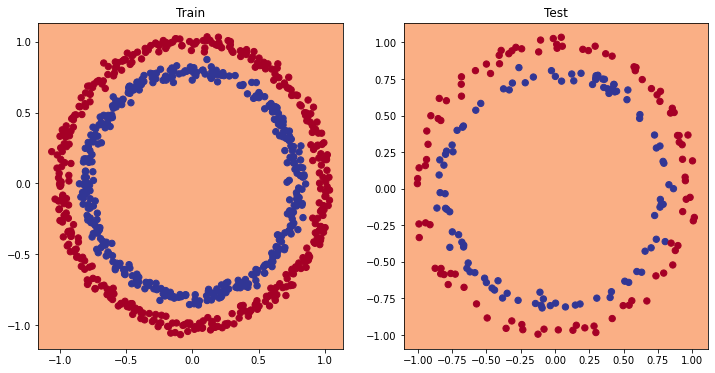

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_0, X_test, y_test)

## Improve Model

In [25]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,X):
    return self.layer_3(self.layer_2(self.layer_1(X)))

Model_1 = CircleModelV1().to(device)
Model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(Model_1.parameters(),
                          lr=0.01)


In [27]:
torch.cuda.manual_seed(42)

epochs =1001
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  Model_1.train()
  # Forward Pass
  y_logits = Model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and accuracy 

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  # Optimzer Zero grad
  optimizer.zero_grad()

  # Back Propagation 
  loss.backward()

  # Gradient Descent 
  optimizer.step()

  ### Testing 
  Model_1.eval()
  with torch.inference_mode():
        # Forward Pass
        test_logits = Model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate Loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

  if (epoch%100==0):
    print(f"Epoch {epoch} Loss {loss} Acc {acc} Test Loss {test_loss} Test Acc {test_acc}")

Epoch 0 Loss 0.6939550638198853 Acc 50.875 Test Loss 0.6926106214523315 Test Acc 51.0
Epoch 100 Loss 0.6936901807785034 Acc 50.24999999999999 Test Loss 0.6926934123039246 Test Acc 50.0
Epoch 200 Loss 0.6935146450996399 Acc 50.125 Test Loss 0.6928169131278992 Test Acc 49.5
Epoch 300 Loss 0.6933882236480713 Acc 50.5 Test Loss 0.692952036857605 Test Acc 49.0
Epoch 400 Loss 0.6932939291000366 Acc 50.375 Test Loss 0.6930880546569824 Test Acc 48.5
Epoch 500 Loss 0.6932223439216614 Acc 49.875 Test Loss 0.6932206749916077 Test Acc 49.5
Epoch 600 Loss 0.6931675672531128 Acc 49.5 Test Loss 0.6933473944664001 Test Acc 53.0
Epoch 700 Loss 0.6931256055831909 Acc 49.375 Test Loss 0.6934669613838196 Test Acc 50.5
Epoch 800 Loss 0.6930931806564331 Acc 50.0 Test Loss 0.6935786008834839 Test Acc 51.0
Epoch 900 Loss 0.6930681467056274 Acc 50.625 Test Loss 0.6936821341514587 Test Acc 47.5
Epoch 1000 Loss 0.6930488348007202 Acc 50.5 Test Loss 0.6937776207923889 Test Acc 49.0


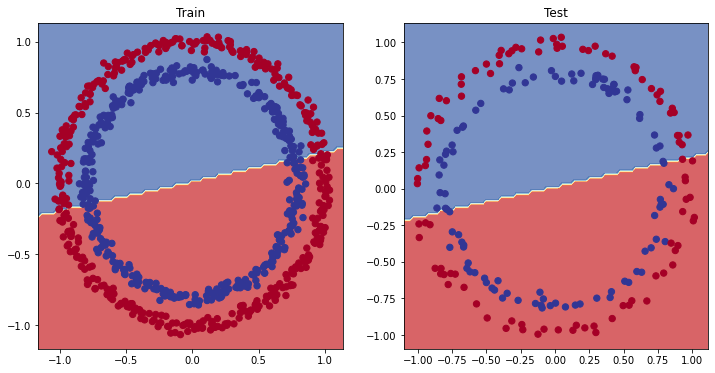

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_1, X_test, y_test)

## Improving Model with Activation function 

In [29]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()
  
  def forward(self,X):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

Model_2 = CircleModelV2().to(device)

In [30]:
Model_2.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.2663,  0.1232, -0

In [31]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(Model_2.parameters(),
                          lr=1.1)

In [32]:
torch.cuda.manual_seed(42)

epochs =1001
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  Model_2.train()
  # Forward Pass
  y_logits = Model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Loss Function and Accuracy 
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)
  
  # Optimizer grad Zero
  optimizer.zero_grad()

  # Back Propagation 
  loss.backward()

  # Gradient Descent 
  optimizer.step()

  # Testing 
  Model_2.eval()
  with torch.inference_mode():
    # Forward Pass
    test_logits =Model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate Loss and Accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_pred)

  if not (epoch %100):
    print(f'Epoch {epoch} | Loss {loss:.5f} | Accuracy {acc} | Test Loss {test_loss:.3f} | Test Accuracy {test_acc}')


Epoch 0 | Loss 0.69441 | Accuracy 50.0 | Test Loss 0.693 | Test Accuracy 50.0
Epoch 100 | Loss 0.66734 | Accuracy 61.375 | Test Loss 0.665 | Test Accuracy 62.0
Epoch 200 | Loss 0.56965 | Accuracy 73.75 | Test Loss 0.575 | Test Accuracy 72.0
Epoch 300 | Loss 0.51921 | Accuracy 69.625 | Test Loss 0.526 | Test Accuracy 67.0
Epoch 400 | Loss 1.31796 | Accuracy 50.5 | Test Loss 0.438 | Test Accuracy 78.5
Epoch 500 | Loss 0.03690 | Accuracy 99.875 | Test Loss 0.064 | Test Accuracy 99.5
Epoch 600 | Loss 0.01059 | Accuracy 100.0 | Test Loss 0.029 | Test Accuracy 100.0
Epoch 700 | Loss 0.00570 | Accuracy 100.0 | Test Loss 0.021 | Test Accuracy 100.0
Epoch 800 | Loss 0.00417 | Accuracy 100.0 | Test Loss 0.018 | Test Accuracy 100.0
Epoch 900 | Loss 0.00331 | Accuracy 100.0 | Test Loss 0.016 | Test Accuracy 100.0
Epoch 1000 | Loss 0.00274 | Accuracy 100.0 | Test Loss 0.015 | Test Accuracy 100.0


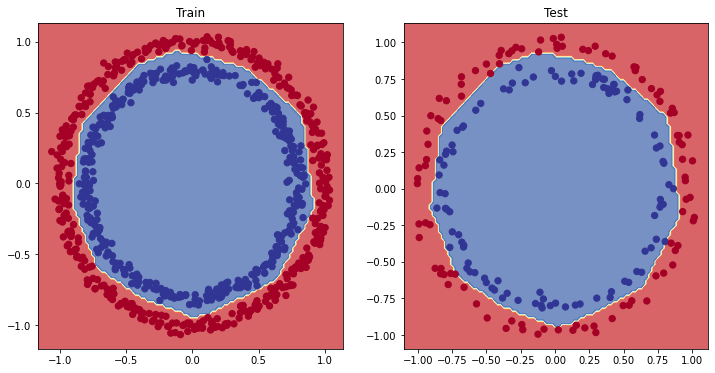

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_2, X_test, y_test)

# Problem 2 - Multi Classification 

## Creating the Data Sets 

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


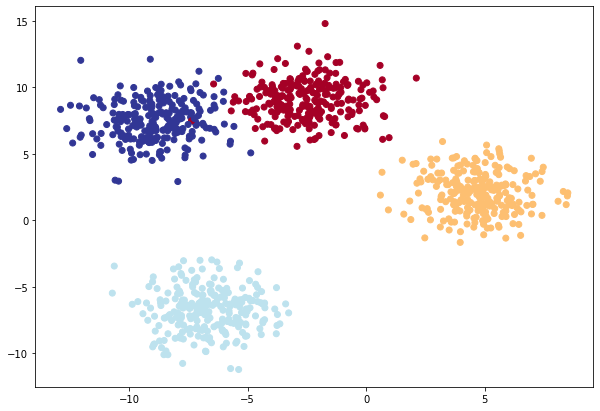

In [34]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [35]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##  Build Model 

In [37]:
class BlobModel(nn.Module):
  def __init__(self , input_features , output_features , hidden_units = 8 ):
    super().__init__()
    self.linear_stack_layer = nn.Sequential(
                                      nn.Linear(in_features = input_features , out_features = hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features = hidden_units , out_features = hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features = hidden_units , out_features = output_features)
                                    )
    
  def forward(self , X ):
    return self.linear_stack_layer(X)
    
Model_4 = BlobModel(2,4)
Model_4.state_dict()


OrderedDict([('linear_stack_layer.0.weight', tensor([[-0.2435, -0.3386],
                      [-0.5755,  0.5929],
                      [-0.2830,  0.1874],
                      [-0.2453,  0.0575],
                      [ 0.6592,  0.3258],
                      [-0.6128,  0.2807],
                      [ 0.6712,  0.1860],
                      [ 0.4741,  0.6971]])),
             ('linear_stack_layer.0.bias',
              tensor([-0.1083,  0.1468, -0.4915, -0.1457,  0.5237,  0.3625, -0.4474, -0.5670])),
             ('linear_stack_layer.2.weight',
              tensor([[-0.2416, -0.3489, -0.2728, -0.0874,  0.2386,  0.0592, -0.2689, -0.2836],
                      [ 0.1759, -0.2630, -0.0435,  0.1696, -0.1636, -0.0386, -0.0308, -0.0836],
                      [-0.1793, -0.3152, -0.2858, -0.1893,  0.3415, -0.1708, -0.2374,  0.0857],
                      [ 0.0974,  0.1937,  0.2687,  0.1969, -0.3505,  0.0314,  0.2142, -0.0327],
                      [-0.2083,  0.3371, -0.1322, -0.2013, -0

## Loss and Optimizer 

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = Model_4.parameters(),lr=0.1)

In [45]:
Model_4.to(device)

BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Build Train and Test Loop  

In [38]:
epochs =1001 

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

In [47]:
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  Model_4.train()

  # Forward Pass
  y_logits = Model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  # Calculate loss and Accuracy
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_blob_train , y_pred)

  # Optimizer zero grad 
  optimizer.zero_grad()

  # Back Propagation 
  loss.backward()

  # Gradient Descent 
  optimizer.step()

  with torch.inference_mode():
    # Forward Pass 
    test_logits = Model_4(X_blob_test)
    test_pred =  torch.softmax(test_logits , dim =1 ).argmax(dim=1)

    # Loss and Accuracy 
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_blob_test , test_pred)

  if not(epoch%100):
    print(f'Epoch {epoch} | loss {loss:.5f} | Accuracy {acc} | Test loss {test_loss : .5f} | Test Accuracy {test_acc}')

Epoch 0 | loss 1.20920 | Accuracy 58.5 | Test loss  1.10247 | Test Accuracy 67.0
Epoch 100 | loss 0.03352 | Accuracy 99.25 | Test loss  0.02418 | Test Accuracy 99.5
Epoch 200 | loss 0.02711 | Accuracy 99.25 | Test loss  0.01703 | Test Accuracy 99.5
Epoch 300 | loss 0.02513 | Accuracy 99.25 | Test loss  0.01458 | Test Accuracy 99.5
Epoch 400 | loss 0.02424 | Accuracy 99.25 | Test loss  0.01341 | Test Accuracy 99.5
Epoch 500 | loss 0.02364 | Accuracy 99.25 | Test loss  0.01263 | Test Accuracy 99.5
Epoch 600 | loss 0.02315 | Accuracy 99.25 | Test loss  0.01203 | Test Accuracy 99.5
Epoch 700 | loss 0.02273 | Accuracy 99.25 | Test loss  0.01157 | Test Accuracy 99.5
Epoch 800 | loss 0.02236 | Accuracy 99.25 | Test loss  0.01117 | Test Accuracy 99.5
Epoch 900 | loss 0.02202 | Accuracy 99.25 | Test loss  0.01079 | Test Accuracy 99.5
Epoch 1000 | loss 0.02170 | Accuracy 99.25 | Test loss  0.01047 | Test Accuracy 99.5


## Visualizing Prediction Results 

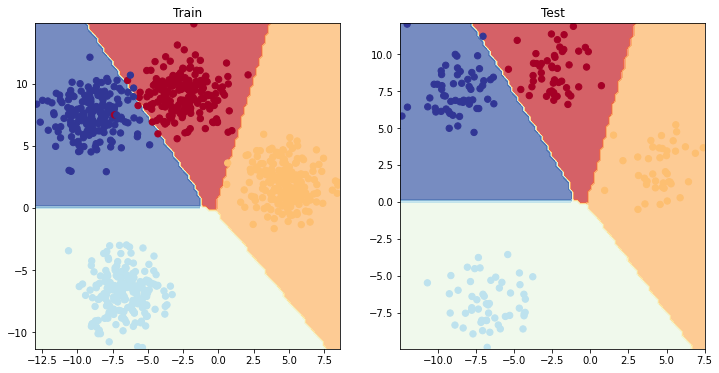

In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_4, X_blob_test, y_blob_test)

## Classification Metrics

In [51]:
!pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(test_pred, y_blob_test)

tensor(0.9950, device='cuda:0')

-------